In [266]:
import pandas as pd
from collections import Counter
import numpy as np
%matplotlib inline
from collections import Counter

In [267]:
df = pd.read_csv("./astro_tag_exif_autotags_clean_quality_datetimes_photo-url_views_faves.csv")

#### Density estimation

In [268]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [269]:
df = df[df.lat.notnull()]

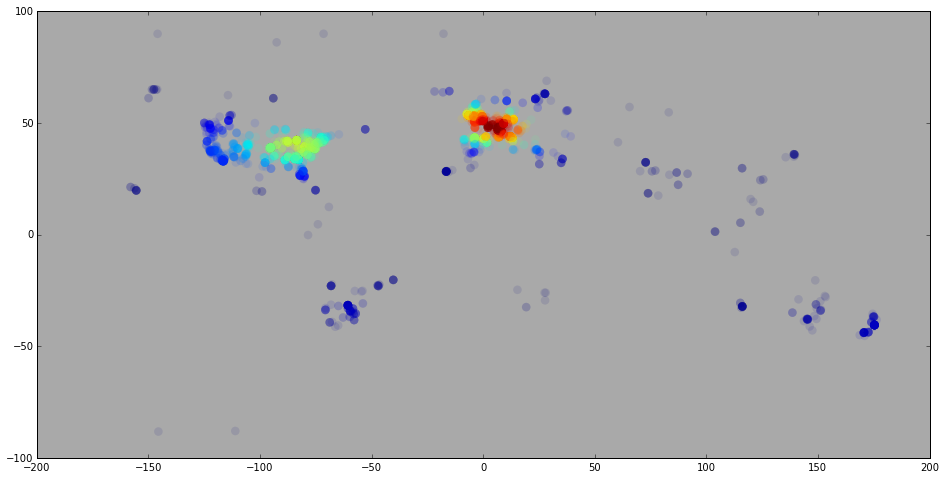

In [270]:
xy = np.vstack([df.lon,df.lat])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df.lon, df.lat, c=z, s=75, edgecolor='',alpha=0.1)
ax.set_axis_bgcolor('darkgrey')

In [271]:
from shapely.geometry import Point

In [272]:
df.reset_index(drop=True,inplace=True)

In [273]:
geopoint = []
for i in range(len(df)):
    geopoint.append(Point(df.lon.loc[i],df.lat.loc[i]))

In [274]:
df['density'] = z
df['geopoint'] = geopoint

In [275]:
df[['geopoint','density','user_nid']].sort('density',ascending=False).head(8)

,geopoint,density,user_nid
3221,POINT (3.941631 49.019915),0.000701,33346666@N07
3206,POINT (3.941802 49.019968),0.000701,33346666@N07
3220,POINT (3.94162 49.020175),0.000701,33346666@N07
3217,POINT (4.026718 49.188659),0.000700,33346666@N07
3223,POINT (4.022254 49.191464),0.000700,33346666@N07
3218,POINT (4.029529 49.231008),0.000699,33346666@N07
3215,POINT (4.029529 49.231008),0.000699,33346666@N07
3219,POINT (4.165935 49.272984),0.000699,33346666@N07


Okay here's the strategy. We want to find the peaks. So, what's a peak? It's not just the highest values. Because around a very high peak, there will be points taller than peaks elsewhere. And we see this is true in the little excerpt of df above. We know there are peaks in various places on the map, but our leaderboard is all in one place (and all from one user, as it turns out).

So, we iterate through a list sorted by density, highest first. Start with row zero. If the point at row one is farther than some stipulated distance, we say it's a new peak. As we go on, we make sure the point we are considering for peakhood is both far enough away from the previous point, and from all points added to the list of peaks. This ensures that we get a good spread of peaks, and that we aren't just finding the highest peak and all its homeboys. If we exceed our limit # peaks with the stipulated distance, we increase the distance and run it again. 

I ran the function below trying for 4 peaks, but the problem is that when 4 peaks is a _max_, the distance gets so high that what we have left aren't really "peaks" in the sense we want. So, what I do instead is let it find, say, 10 peaks, and then just take the highest of those 10. This way, we don't push the distance up too high. The results with this approach were excellent: they gave us a good spread of high peaks. 

Really, what we did was take the 4 highest peaks from some criterion we were okay with.

In [276]:
def density_peaks(num_peaks,crit_init):
    tmp = df.sort('density',ascending=False)
    
    crit_dist = crit_init
    peaks = num_peaks + 1
    
    while peaks > num_peaks:
        peak_list = []
        counter=-1
        for idx in tmp.index:
            counter+=1
            if counter==0:
                peak_list.append(idx)
            else:
                pos_idx = list(tmp.index).index(idx)
                pt = tmp.geopoint.loc[idx]
                prev_pt = tmp.geopoint.loc[tmp.index[pos_idx-1]]
                dist = pt.distance(prev_pt)
                if dist >= crit_dist:
                    if all(pt.distance(df.geopoint.loc[peak]) >= crit_dist for peak in peak_list):
                        peak_list.append(idx)
        
        if len(peak_list) < num_peaks:
            print len(peak_list)
            peaks = len(peak_list)
        elif len(peak_list)==num_peaks:
            peaks = len(peak_list)
        else:
            crit_dist+=1
            print len(peak_list)
    return peak_list

In [277]:
density_peaks(10,50)

11
11
11
11
11
11
11
11
11
11


[3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656, 3892, 3893]

In [161]:
#df[['lat','lon']].loc[[3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656, 3892, 3893]].to_csv("./peaks.csv",index=False)

In [278]:
peak_idxs = [3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656, 3892, 3893]

### Hotspots

In [280]:
peaks = df[['lat','lon']].loc[[3221, 2059, 1766, 2152]] # top 4

We will take top 4 hotspots, given what we learned in geo-bust.ipynb.

1. For each hotspot, we need to find the lat and lon offset from that spot for each point in our data.
2. Once we've done this, we can calculate the mile distance, factoring in latitude for our lon calculation.
3. Then we use these offsets to compute straight-line distance.
4. We then choose all points some chosen straight-line distance away.

[note: You might ask, "Well that's all fine and good, but how do you compute the offsets in the first place, given the problem of meridian convergence?" Good question. In truth, the straight-line calculation between far off points will be inaccurate, but it doesn't matter because in the end, we are selecting only points near the hotspot. Those points should be pretty accurate.]

In [281]:
peaks['peak_num'] = ['p1','p2','p3','p4']

In [282]:
# Latitude: 1 deg = 110.574 km
# Longitude: 1 deg = 111.320*cos(latitude) km

# we need radians...

In [283]:
for i in peaks.index:
    peak_num = peaks.peak_num.loc[i]
    lat = peaks.lat.loc[i]
    lon = peaks.lon.loc[i]
    
    km = []
    for j in range(len(df)):
        a = abs(df.lat.loc[j] - lat) * 110.574 
        b = abs(df.lon.loc[j] - lon) * 111.320 * np.cos(np.radians(lat)) # convergence of meridians thing
        c = np.sqrt( a**2 + b**2 ) # distance formula
        km.append(c)
    
    df[peak_num+"_km"] = km

Let's take a look at these results by seeing, for each peak, how many other photos are nearby, for various degrees of "nearby".

In [358]:
distances = np.arange(0,2500,1)
#d_miles = [d*0.621 for d in distances]
p1 = [len(df[df.p1_km < d]) for d in distances]
p2 = [len(df[df.p2_km < d]) for d in distances]
p3 = [len(df[df.p3_km < d]) for d in distances]
p4 = [len(df[df.p4_km < d]) for d in distances]

In [359]:
import matplotlib.patches as mpatches

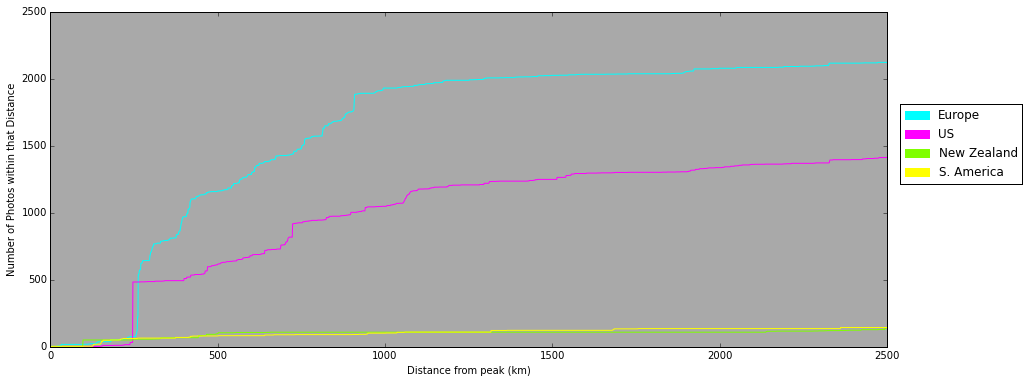

In [378]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(distances, p1, c="cyan")
ax.plot(distances, p2, c="magenta")
ax.plot(distances, p3, c="chartreuse")
ax.plot(distances, p4, c="yellow")
ax.set_axis_bgcolor('darkgrey')
ax.set_xlabel("Distance from peak (km)")
ax.set_ylabel("Number of Photos within that Distance")

cyan_patch = mpatches.Patch(color='cyan', label='Europe')
magenta_patch = mpatches.Patch(color='magenta', label='US')
chartreuse_patch = mpatches.Patch(color='chartreuse', label='New Zealand')
yellow_patch = mpatches.Patch(color='yellow', label='S. America')
ax.legend(handles=[cyan_patch,magenta_patch,chartreuse_patch,yellow_patch],
          bbox_to_anchor=(1.03, 0.7),
          bbox_transform=plt.gcf().transFigure)
plt.savefig("./peak_curves.png",bbox_inches="tight")

We can see that the South American and New Zealand (green and yellow) spots are pretty isolated: they don't add lots of additional photos as we increase the perimeter (now of course, in the limit, all lines will converge). The US and Europe spots, however, are amongst such dense regions of astro activity that the curves continue to go up. Let's look more closely at just NZ and S.Am:

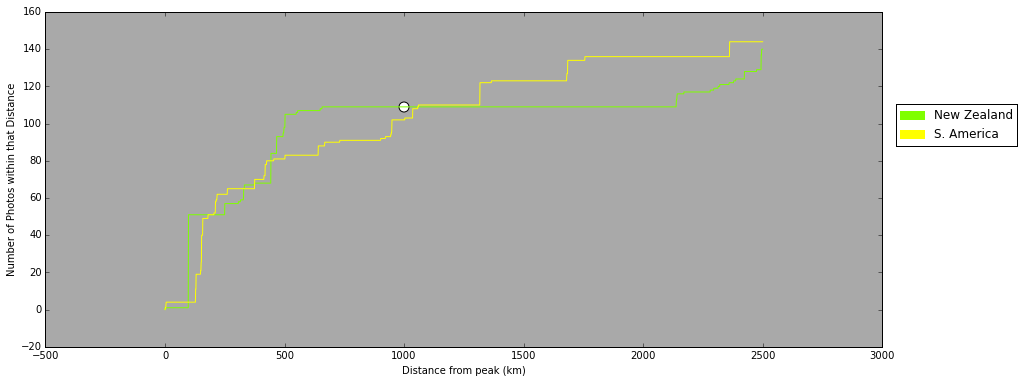

In [377]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(distances, p3, c="chartreuse")
ax.plot(distances, p4, c="yellow")
ax.scatter(1000,109,c="white",s=100)
ax.set_axis_bgcolor('darkgrey')
ax.set_xlabel("Distance from peak (km)")
ax.set_ylabel("Number of Photos within that Distance")

ax.legend(handles=[chartreuse_patch,yellow_patch],
          bbox_to_anchor=(1.03, 0.7),
          bbox_transform=plt.gcf().transFigure)
plt.savefig("./peak_curves_zoom.png",bbox_inches="tight")

Okay this looks like a reasonable cutoff: 1000km. That is about 621 miles. A circle with a 1000 km radius covers all of New Zealand but not much more, and it is around this cutoff that even the US and Europe hotspots start to level off somewhat. So we will now concern ourselves to look for each peak at the photos within 1000 km.

In [370]:
eu = df[df.p1_km <= 1000]
us = df[df.p2_km <= 1000]
nz = df[df.p3_km <= 1000]
sa = df[df.p4_km <= 1000]

In [371]:
print len(eu),len(us),len(nz),len(sa)

1932 1049 109 102


We will do a number of things with these "hotspots". First, we will look at the photo content, the number of user accounts, the associated Google Streetview images (to get a sense of what these sites look like), and the camera models. We will also look at street maps from above, zoomed in, to see these regions more closely. But we will do all that in other notebooks.

In [379]:
eu.to_csv("./hs_eu.csv",index=False)
us.to_csv("./hs_us.csv",index=False)
nz.to_csv("./hs_nz.csv",index=False)
sa.to_csv("./hs_sa.csv",index=False)